# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

from tqdm import tqdm_notebook

# %matplotlib inline
%matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
from plasticc_plotting import plot_light_curve

# Load data

In [2]:
# define path to dataset
pathToFile = "/home/leo/Downloads/plasticc_torch/"
# path to file in guanaco
# pathToFile = "/home/shared/astro/PLAsTiCC/"

# path to file in local 
# pathToFile = "/home/leo/Downloads/plasticc_torch/"

## Loading dataset with pytorch tool

In [3]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=[16, 92])

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 1 csv files at given path
Loading /home/leo/Downloads/plasticc_torch/plasticc_train_lightcurves.csv


# Spliting data (train/test)

In [4]:
# Spliting the data

# selecting train splitting
train_size = int(0.8 * torch_dataset_lazy.__len__())

# getting test splitting
test_size = torch_dataset_lazy.__len__() - train_size

# spliting the torch dataset
trainDataset, testDataset = torch.utils.data.random_split(torch_dataset_lazy, [train_size, test_size])

## Create a dataloader

In [5]:
# # Create data loader (minibatches)

# # train loader
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=256, shuffle=False, num_workers = 4)

# # test loader
testLoader = torch.utils.data.DataLoader(testDataset)
# trainLoader = torch.utils.data.DataLoader(torch_dataset_lazy, batch_size=256, shuffle=True, num_workers=0)

In [6]:
# # check data loader shape

# # training
# print("#### TRAINING ####")
# print("minibatches trainig: ", len(list(trainLoader)))
# print("minibatch trainig size: ", list(trainLoader)[0][0].shape)


# # testing
# print("\n#### TESTING ####")
# print("minibatches test: ", len(list(testLoader)))
# print("minibatch trainig size: ", list(testLoader)[0][0].shape)

## Define autoencoder structure
To start with the work, It is going to build a very basic Autoencoder

In [7]:
# Buiding autoencoder

# Assuming this has a normal distrubtion in the latent part

# encoder
class Encoder(torch.nn.Module):
    
    # init method
    def __init__(self, latent_dim, hidden_dim, input_dim):

        super(Encoder, self).__init__()
        
        # 1 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
        self.conv1 = torch.nn.Conv1d(1,64,3)
        
        # this is to consider time and magnitude
        # we should use shared weights?
        self.conv1Time = torch.nn.Conv1d(1, 64, 3)
        self.conv1Mag = torch.nn.Conv1d(1, 64, 3)
        
        # 2 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
        self.conv2 = torch.nn.Conv1d(64, 32, 3)
        
        # time and magnitude conv
        self.conv2Time = torch.nn.Conv1d(64, 32, 3)
        self.conv2Mag = torch.nn.Conv1d(64, 32, 3)
        
        # linear layer
        self.hidden1 = torch.nn.Linear(2144*2, hidden_dim)
        
        # mu
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        
        # sigma
        self.logVar = torch.nn.Linear(hidden_dim, latent_dim)
        
        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()

    # forward method
    def forward(self, x):
        
        # input shape: [batch_size, channels, sequence_length]
        # print("input shape: {0}".format(x.shape))
        
        
        # convolution 1
        # x -> conv -> act -> ouput
        # shape should be: [batch_size, number of ouput channels (64), length of output from convolution]

        #conv to time
        outputTimeConv = self.activationConv(self.conv1Time(x[:, 0, :].unsqueeze(1)))
        
        # conv to magnitude
        outputMagConv = self.activationConv(self.conv1Mag(x[:, 1, :].unsqueeze(1)))
        
#         print("output conv1 shape: {0}".format(outputMagConv.shape))
#         print("output conv1 shape: {0}".format(outputTimeConv.shape))
        
        # convolution 2
#         # shape should be: [batch_size, number of ouput channels (32), length of output from convolution]
        
        # conv to time
        outputTimeConv = self.activationConv(self.conv2(outputTimeConv))
    
        # conv to flux
        outputMagConv = self.activationConv(self.conv2(outputMagConv))
        
#         print("output conv2 shape: {0}".format(outputTimeConv.shape))
#         print("output conv2 shape: {0}".format(outputMagConv.shape))
        
        # flatten ouput
        # shape should be: [batch_size, -1]
        outputMagConv = outputMagConv.view(outputMagConv.shape[0], -1)
        outputTimeConv = outputTimeConv.view(outputTimeConv.shape[0], -1)
        
#         print("output reshape: ", outputMagConv.shape)
#         print("output reshape: ", outputTimeConv.shape)
                
        # concatenate 2 towers
        output = torch.cat((outputMagConv, outputTimeConv), 1)
#         print("concatenate output shape: ", output.shape)
        
        # x -> hidden1 -> activation
        output = self.activationLinear(self.hidden1(output))
#         print("hidden1 output shape: {0}".format(output.shape))
        
        # get mu
        # sin tangenteh!!!
        mu = self.mu(output)
#         print("mu shape: {0}".format(mu.shape))
        
        # get sigma
        logVar = self.logVar(output)
#         print("sigma shape: {0}".format(logVar.shape))
        
        # returning values
        return mu, logVar

    
# decoder    
class Decoder(torch.nn.Module):
    
    # define layers
    def __init__(self, latent_dim, hidden_dim, output_dim):
        
        super(Decoder, self).__init__()
        
        # linear layer
        self.hidden1 = torch.nn.Linear(latent_dim, 2144*2)
        
        # 1 ConvolutionTrans layer
        self.convTrans1 = torch.nn.ConvTranspose1d(32, 64, 3)
        
        # 2 ConvolutionTrans layer
        self.convTrans2 = torch.nn.ConvTranspose1d(64, 1, 3)

        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()
        
    # forward method
    def forward(self, z):
        
#         print("input dimension decoder: {0}".format(z.shape))
        
        # linear (from latent to hidden dimension)
        # z -> linaer layer -> activation -> output
        output = self.activationLinear(self.hidden1(z))
#         print("output hidden1: {0}".format(output.shape))
        
        # split data (into time and flux)
        outputTimeDeconv, outputMagDeconv = torch.split(output, 2144, dim=2)
            
        # reshape each tower (time and magnitude)
        outputTimeDeconv = outputTimeDeconv.view(outputTimeDeconv.shape[0], 32, -1)
        outputMagDeconv = outputMagDeconv.view(outputMagDeconv.shape[0], 32, -1)
        
#         print("output reshape: {0}".format(outputTimeDeconv.shape))
#         print("output reshape: {0}".format(outputMagDeconv.shape))
        
        # 1 convolution
        outputTimeDeconv = self.activationConv(self.convTrans1(outputTimeDeconv))
        outputMagDeconv = self.activationConv(self.convTrans1(outputMagDeconv))
#         print("ouput convTrans1: {0}".format(outputTimeDeconv.shape))
#         print("ouput convTrans1: {0}".format(outputMagDeconv.shape))
        
        # 2 convolution
        outputTimeDeconv = self.convTrans2(outputTimeDeconv)
        outputMagDeconv = self.convTrans2(outputMagDeconv)
        
#         print("ouput convTrans2: {0}".format(outputTimeDeconv.shape))
#         print("ouput convTrans2: {0}".format(outputMagDeconv.shape))
        
        # concatenate arrays in order to get the data with 2 channels
        output = torch.cat((outputTimeDeconv, outputMagDeconv), 1)
#         print("concatenate in channels: {0}".format(output.shape))

        # output
        return output

# building the autoencoder     
class AutoEncoder(torch.nn.Module):
    
    # defining the initial structure
    def __init__(self, latent_dim, hidden_dim, input_dim):
        
        super(AutoEncoder, self).__init__()
        
        # defining the encoder
        self.encoder = Encoder(latent_dim, hidden_dim, input_dim)
        
        # defining the decoder
        # note the output dimension in the decoder is the same as input dimension
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    # distribution function
    def sampling(self, mu, logvar, k = 1):
        
        # assumming normal distribution
#         s = torch.exp(0.5*sigma)
#         eps = torch.rand_like(s) # generate a iid standard normal same shape as s
#         return eps.mul(s).add_(mu)
        batch_size, n_latent = logvar.shape
        std = (0.5*logvar).exp()
#         eps = torch.randn(batch_size, k, n_latent, device=std.device, requires_grad=False)
        eps = torch.randn(batch_size, k, n_latent, requires_grad=False)
        if "cuda" in str(mu.device):
            eps = eps.cuda()
        return eps.mul(std.unsqueeze(1)).add(mu.unsqueeze(1))
    
    # forward method (how to the nn works)
    def forward(self, x):
        
#         print("input size: {0}".format(x.shape))
        
#         print("## Encoder ##")
        # input (x) -> encoder -> latent variables
        mu, logVar = self.encoder(x)
#         print("output encoder size: {0}".format(mu.shape))
        
#         print("mu ", mu.device)
#         print("var ", logVar.device)
        # getting sample
        # mu, sigma -> distribution -> z
        z = self.sampling(mu, logVar)
#         print("z shape: ", z.shape)
        
#         print("## Dencoder ##")
        # latent variables -> decoder -> reconstruction (x)
        decOutput = self.decoder(z)
#         print("output decoder size: {0}".format(decOutput.shape))
        
        return decOutput

# Load model

In [96]:
num_experiment = 7

# model path
pathToSaveModel = "/home/leo/Desktop/thesis/work/thesis/experiments/" + str(num_experiment) +"/"
# pathToSaveModel = "/home/lbravo/thesis/work/thesis/experiments/1/model_guanaco_1"

In [99]:
# check number of parameters
latentDim = 60
hiddenDim = 20
inputDim = 72

# defining model
model = AutoEncoder(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim)

# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(pathToSaveModel + "model"))

<All keys matched successfully>

In [100]:
model

AutoEncoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (conv1Time): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (conv1Mag): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (conv2Time): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (conv2Mag): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (hidden1): Linear(in_features=4288, out_features=20, bias=True)
    (mu): Linear(in_features=20, out_features=60, bias=True)
    (logVar): Linear(in_features=20, out_features=60, bias=True)
    (activationConv): ReLU()
    (activationLinear): Tanh()
  )
  (decoder): Decoder(
    (hidden1): Linear(in_features=60, out_features=4288, bias=True)
    (convTrans1): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,))
    (convTrans2): ConvTranspose1d(64, 1, kernel_size=(3,), stride=(1,))
    (activationConv): ReLU()
    (activationLinear): Tanh()
  )
)

# Analyze training

<IPython.core.display.Javascript object>


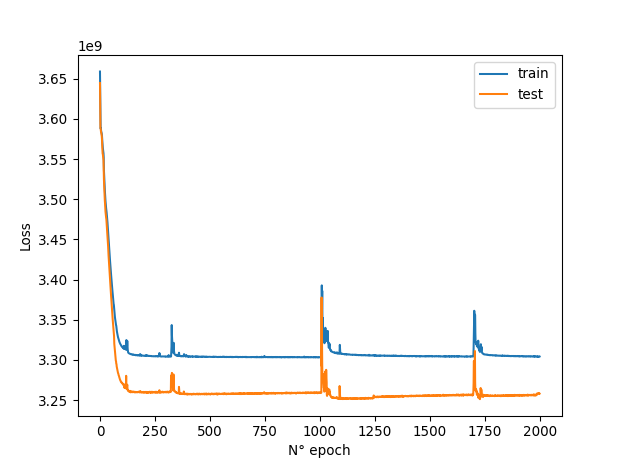

In [101]:
# load losses array
losses = pd.read_csv(pathToSaveModel + "training_losses.csv")

# plot losses
fig, ax = plt.subplots()

# axis
ax.set_xlabel("N° epoch")
ax.set_ylabel("Loss")

# plot
ax.plot(losses.iloc[:, 0], label = "train")
ax.plot(losses.iloc[:, 1], label = "test")
ax.legend()

# Analize model metrics

In [102]:
f = open(pathToSaveModel + "bestScoresModelTraining.txt", "r")
print(f.read())

Epoch: 1105
 Reconstruction test error: 757537173275.5


# Reconstructed light curve

In [27]:
# from torchvision import transforms

# normalize light curve
# data: [batch size, 2 channels (time and magnitude), light curve length]
def normalizeLightCurve(data):
    
#     print("data shape before normalization: ", data.shape)
    
    # get flux mean
    means = data[:, 1, :].mean(dim=1)
#     print("mean shape: ", means.shape)
    
    # get flux standar deviation 
    stds = data[:, 1, :].std(dim=1)
#     print("stds shape: ", stds.shape)
    
    # overwrite flux
    data[:, 1, :] = (data[:, 1, :] - means.unsqueeze(1).expand_as(data[:, 1, :])) / stds.unsqueeze(1).expand_as(data[:, 1, :])
#     print("normalized data shape: ", data.shape)
    
    # return normalized data
    return data

In [28]:
# function to generate delta time and flux
# data = [batchSize, channels, [time, flux, err, mask], light curve]
def generateDeltas(data, passBand):
    
    # work with delta time and magnitude
    
#     print("generate deltas input shape: {0}".format(data.shape) )
    # delta time
    tmpDeltaTime = data[:, passBand, 0, 1:] - data[:, passBand, 0, :-1]

#     print("generate deltas time shape: {0}".format(tmpDeltaTime.shape) )

#     # delta magnitude
    tmpDeltaMagnitude = data[:, passBand, 1, 1:] - data[:, passBand, 1, :-1]
#     print("generate deltas flux shape: {0}".format(tmpDeltaMagnitude.shape))
    
    # concatenate tensors
    dataToUse = torch.cat((tmpDeltaTime.unsqueeze(1), tmpDeltaMagnitude.unsqueeze(1)), 1)
#     print("data to use shape: {0}".format(dataToUse.shape))
    
    # normalize data
    dataToUse = normalizeLightCurve(dataToUse)
    
    # returning data
    return dataToUse

In [66]:
# from thesis_experiments import generateDeltas

# reconstruction
# print(list(trainLoader)[0][0].shape)

lightCurve = list(trainLoader)[0][0]

# print(lightCurve.shape)

# masks = lightCurve[:, 5, 3, :].bool()
# print(masks)

# original data
lightCurveDeltas = generateDeltas(lightCurve, 5)
print(lightCurveDeltas.shape)

# reconstructed data
reconstructedLightCurve = model.forward(lightCurveDeltas)

# to numpy
lightCurveDeltas = lightCurveDeltas.detach().numpy()
reconstructedLightCurve = reconstructedLightCurve.detach().numpy()

# lighCurveReconstructuredNoDelta = lightCurveDeltas + lightCurve[:, 5, 0:2, 0].detach().numpy()

for i in range(0, )

print(lightCurve[:, 5, 1:2, 0].shape)
# print(lightCurveDeltas.shape)
# print(reconstructedLightCurve.shape)

lID = 200

fig, ax = plt.subplots(figsize = (3,3))

ax.set_title("Delta data (time and magnitude)")

# origingal data
ax.scatter(lightCurveDeltas[lID, 0, :], lightCurveDeltas[lID, 1, :], label = "original")

# reconstructed data
ax.scatter(reconstructedLightCurve[lID, 0, :], reconstructedLightCurve[lID, 1, :], label = "reconstructed")

ax.legend()

torch.Size([256, 2, 71])


ValueError: operands could not be broadcast together with shapes (256,2,71) (256,2) 